In [1]:
import dqc
import torch
import xitorch.optimize
import time

In [2]:
dtype = torch.float64
dev = torch.tensor([0.0], dtype=dtype).requires_grad_()
basis_321g = dqc.loadbasis("7:pc-2")

def fcn(dist, dev):
    atompos = torch.tensor([[-0.5, 0, 0], [0.5, 0, 0]], dtype=dtype) * dist
    atomzs = torch.cat((7. + dev, 7. - dev), dim=0)
    m = dqc.Mol((atomzs, atompos), basis=[basis_321g, basis_321g], spin=0)
    ene = dqc.HF(m).run().energy()
    return ene


In [3]:
t0 = time.time()
print("Finding the equilibrium position")
dist = torch.tensor(2.05, dtype=dtype).requires_grad_()
equil_atompos = xitorch.optimize.minimize(fcn, dist, (dev,), method="gd",
                                          step=1e-1, maxiter=200, f_rtol=1e-10,
                                          verbose=True)
equil_ene_n2 = fcn(equil_atompos, dev)
print(time.time() - t0)

Finding the equilibrium position
   #:             f |        dx,        df
   1: -1.089860e+02 | 6.737e-03, 1.090e+02
  10: -1.089872e+02 | 9.812e-03, 2.528e-04
  20: -1.089872e+02 | 1.732e-03, 7.131e-05
  30: -1.089872e+02 | 3.131e-03, 2.957e-05
  40: -1.089873e+02 | 1.087e-03, 6.952e-06
  50: -1.089873e+02 | 9.194e-04, 2.603e-06
  60: -1.089873e+02 | 5.307e-04, 3.454e-07
  70: -1.089873e+02 | 2.344e-04, 1.115e-07
  80: -1.089873e+02 | 2.225e-04, 3.451e-08
Finish with convergence
  87: -1.089873e+02 | 1.491e-04, 8.266e-09
115.78965258598328


In [4]:
# gradient of the equilibrium position w.r.t. dev
t0 = time.time()
gposdev, = torch.autograd.grad(equil_atompos, dev, create_graph=True)
gposdev2, = torch.autograd.grad(gposdev, dev, retain_graph=True)
gposdev = gposdev.detach()
gposdev2 = gposdev2.detach()
t1 = time.time()
print(gposdev, gposdev2, t1 - t0)
genedev, = torch.autograd.grad(equil_ene_n2, dev, create_graph=True)
genedev2, = torch.autograd.grad(genedev, dev, retain_graph=True)
genedev = genedev.detach()
genedev2 = genedev2.detach()
t2 = time.time()
print(genedev, genedev2, t2 - t1)

tensor([3.8512e-11], dtype=torch.float64) tensor([-0.3642], dtype=torch.float64) 72.02341437339783
tensor([-5.3038e-12], dtype=torch.float64) tensor([-4.9634], dtype=torch.float64) 77.88188409805298


In [5]:
devs = torch.linspace(-2.0, 2.0, 41, dtype=dtype)
dist0 = torch.tensor(2.0, dtype=dtype)
equil_dists = []
equil_enes = []
for i, dev2 in enumerate(devs):
    print(i, dev2)
    equil_dist = xitorch.optimize.minimize(fcn, dist0, (dev2.unsqueeze(0),), method="gd",
                                           step=1e-2, maxiter=2000, f_rtol=1e-10,
                                           verbose=True)
    dist0 = equil_dist.detach()
    equil_dists.append(equil_dist.detach())
    equil_enes.append(fcn(equil_dist, dev2.unsqueeze(0)).detach())

0 tensor(-2., dtype=torch.float64)
   #:             f |        dx,        df
   1: -1.193464e+02 | 1.262e-02, 1.193e+02
  10: -1.203878e+02 | 8.200e-02, 7.112e-02
  20: -1.202691e+02 | 1.318e-02, 1.642e-02
  30: -1.204157e+02 | 2.973e-02, 2.742e-02
  40: -1.204562e+02 | 2.150e-02, 8.912e-03
  50: -1.204592e+02 | 1.021e-02, 7.144e-04
  60: -1.204582e+02 | 2.672e-03, 9.575e-04
  70: -1.204589e+02 | 1.188e-03, 7.293e-05
  80: -1.204597e+02 | 2.035e-03, 1.232e-04
  90: -1.204599e+02 | 1.540e-03, 4.642e-05
 100: -1.204599e+02 | 7.736e-04, 1.223e-06
 110: -1.204599e+02 | 2.095e-04, 4.819e-06
 120: -1.204599e+02 | 6.912e-05, 5.867e-07
 130: -1.204599e+02 | 1.394e-04, 5.820e-07
 140: -1.204599e+02 | 1.100e-04, 2.507e-07
Finish with convergence
 150: -1.204599e+02 | 5.734e-05, 2.694e-09
1 tensor(-1.9000, dtype=torch.float64)
   #:             f |        dx,        df
   1: -1.192672e+02 | 3.022e-03, 1.193e+02
  10: -1.192694e+02 | 2.502e-03, 1.451e-04
  20: -1.192704e+02 | 2.582e-03, 1.874e-04

  50: -1.098928e+02 | 1.723e-05, 5.061e-07
  60: -1.098928e+02 | 3.616e-04, 1.355e-06
  70: -1.098928e+02 | 1.306e-04, 1.936e-07
Finish with convergence
  76: -1.098928e+02 | 1.841e-05, 3.306e-09
15 tensor(-0.5000, dtype=torch.float64)
   #:             f |        dx,        df
   1: -1.096108e+02 | 8.375e-04, 1.096e+02
  10: -1.096123e+02 | 3.807e-03, 1.487e-04
  20: -1.096126e+02 | 1.439e-03, 1.839e-05
  30: -1.096126e+02 | 6.413e-04, 9.094e-06
  40: -1.096127e+02 | 8.243e-04, 4.315e-06
  50: -1.096127e+02 | 1.708e-04, 9.120e-07
  60: -1.096127e+02 | 2.087e-04, 6.886e-07
  70: -1.096127e+02 | 1.552e-04, 4.760e-08
Finish with convergence
  71: -1.096127e+02 | 1.388e-04, 3.992e-09
16 tensor(-0.4000, dtype=torch.float64)
   #:             f |        dx,        df
   1: -1.093853e+02 | 5.481e-04, 1.094e+02
  10: -1.093860e+02 | 2.549e-03, 6.824e-05
  20: -1.093861e+02 | 9.655e-04, 8.902e-06
  30: -1.093861e+02 | 4.756e-04, 4.822e-06
  40: -1.093861e+02 | 5.463e-04, 1.558e-06
  50: -1.093

  40: -1.135679e+02 | 4.029e-04, 1.458e-05
  50: -1.135679e+02 | 2.933e-04, 4.982e-06
  60: -1.135679e+02 | 2.022e-04, 1.620e-06
  70: -1.135679e+02 | 1.362e-04, 4.985e-07
Finish with convergence
  79: -1.135679e+02 | 1.187e-04, 6.487e-09
34 tensor(1.4000, dtype=torch.float64)
   #:             f |        dx,        df
   1: -1.143473e+02 | 2.512e-03, 1.143e+02
  10: -1.143495e+02 | 1.145e-04, 2.318e-04
  20: -1.143503e+02 | 2.007e-04, 6.801e-05
  30: -1.143505e+02 | 1.780e-04, 2.141e-05
  40: -1.143506e+02 | 1.464e-04, 6.121e-06
  50: -1.143507e+02 | 1.088e-04, 1.741e-06
  60: -1.143507e+02 | 7.796e-05, 4.459e-07
  70: -1.143507e+02 | 5.389e-05, 1.012e-07
  80: -1.143507e+02 | 3.647e-05, 1.525e-08
Finish with convergence
  90: -1.143507e+02 | 2.423e-05, 1.670e-09
35 tensor(1.5000, dtype=torch.float64)
   #:             f |        dx,        df
   1: -1.151965e+02 | 2.557e-03, 1.152e+02
  10: -1.151985e+02 | 6.762e-04, 1.592e-04
  20: -1.151993e+02 | 8.279e-04, 1.262e-05
  30: -1.15199

In [6]:
import matplotlib.pyplot as plt

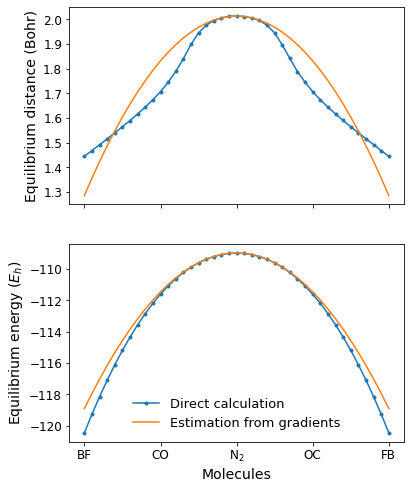

In [7]:
tick_fontsize = 12
label_fontsize = 14
legend_fontsize = 13
plt.figure(figsize=(6, 8))
for i in range(2):
    plt.subplot(2, 1, i + 1)
    if i == 0:
        estimated_poss = equil_atompos.detach() + gposdev.detach() * devs + gposdev2.detach() * devs * devs / 2
        plt.plot(devs, equil_dists, '.-', label="Direct calculation")
        plt.plot(devs, estimated_poss,
                 label="Estimation from gradients")
    else:
        estimated_enes = equil_ene_n2.detach() + genedev.detach() * devs + genedev2.detach() * devs * devs / 2
        plt.plot(devs, equil_enes, '.-', label="Direct calculation")
        plt.plot(devs, estimated_enes,
                 label=r"Estimation from gradients")
    plt.yticks(fontsize=tick_fontsize)
    if i == 0:
        plt.xticks([-2, -1, 0, 1, 2], ["BF", "CO", "N$_2$", "OC", "FB"], fontsize=tick_fontsize, color="white")
    else:
        plt.xticks([-2, -1, 0, 1, 2], ["BF", "CO", "N$_2$", "OC", "FB"], fontsize=tick_fontsize)
        plt.xlabel("Molecules", fontsize=label_fontsize)
    if i == 0:
        plt.ylabel("Equilibrium distance (Bohr)", fontsize=label_fontsize)
    else:
        plt.ylabel("Equilibrium energy ($E_h$)", fontsize=label_fontsize)
        plt.legend(fontsize=legend_fontsize, frameon=False)

In [8]:
print(estimated_poss[0] - equil_dists[0])
print(estimated_poss[10] - equil_dists[10])

tensor(-0.1594, dtype=torch.float64)
tensor(0.1250, dtype=torch.float64)


In [9]:
print(estimated_enes[0] - equil_enes[0])
print(estimated_enes[10] - equil_enes[10])

tensor(1.5458, dtype=torch.float64)
tensor(0.1424, dtype=torch.float64)


In [10]:
print(estimated_poss[0])
print(estimated_poss[10])

tensor(1.2850, dtype=torch.float64)
tensor(1.8313, dtype=torch.float64)


In [11]:
print(equil_dists[0])
print(equil_dists[10])

tensor(1.4444, dtype=torch.float64)
tensor(1.7063, dtype=torch.float64)
